In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from collections import defaultdict

import cv2
import random

import numpy as np
from tqdm import tqdm
import time

cwd = os.getcwd()
sys.path.insert(1, os.path.dirname(cwd))
sys.path.insert(1, cwd)
os.chdir("/srv/flash1/aramacha35/cos-hab2-v2")
from habitat.core.registry import registry

import habitat_sim
import habitat
import gzip
import os
import json
from cos_eor.task.sensors import *
from cos_eor.sim.actions import *
from cos_eor.explore.sensors import *
from cos_eor.task.measures import *
from cos_eor.explore.sim import *
# from cos_eor.play_utils import (
#     make_video_cv2, init_agent, init_objects, build_episode,
#     make_cfg, rearrange_config, test_raycast
# )
import pandas as pd
from habitat.utils.visualizations.utils import images_to_video

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image, ImageFont, ImageDraw
from habitat_sim.utils.viz_utils import is_notebook, display_video, get_fast_video_writer
# from cos_eor.utils.debug import get_corners, \
#     set_object_in_front_of_agent, set_art_object_in_front_of_agent
from cos_eor.utils.geometry import get_surface_center_from_corners
from cos_eor.explore.utils.play_geometry import process_odometer, compute_egocentric_coors

# we only load the base-level config here
config = habitat.get_config("cos_eor/configs/local/nav_sp/ihlen_1_int.yaml")
config = habitat.get_config_new([config.BASE_TASK_CONFIG])
config.defrost()
config.TASK.TOP_DOWN_MAP.FOG_OF_WAR.DRAW = False
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)


# config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'EOR_TOP_DOWN_MAP']
# config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP_POSE']
config.TASK.MEASUREMENTS = []
# config.TASK.SENSORS = ['GRIPPED_OBJECT_SENSOR', 'ALL_OBJECT_POSITIONS', 'ALL_OBJECT_GOALS', 'ORACLE_NEXT_OBJECT_SENSOR',]
# config.TASK.SENSORS = ['GRIPPED_OBJECT_SENSOR', 'FINE_OCC_SENSOR']
config.SIMULATOR.AGENT_0.SENSORS.append("RGB_SENSOR_3RD_PERSON")
# config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 1024
# config.SIMULATOR.DEPTH_SENSOR.WIDTH = 1024
# config.SIMULATOR.RGB_SENSOR.HEIGHT = 1024
# config.SIMULATOR.RGB_SENSOR.WIDTH = 1024
# config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = 1024
# config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = 1024
config.SIMULATOR.CROSSHAIR_POS = [256, 256]
config.SIMULATOR.TURN_ANGLE = 30
config.SIMULATOR.RGB_SENSOR_3RD_PERSON.HEIGHT = 512
config.SIMULATOR.RGB_SENSOR_3RD_PERSON.WIDTH = 512
# config.TASK.EOR_TOP_DOWN_MAP.MAX_RESOLUTION = 1024
# config.TASK.EOR_TOP_DOWN_MAP.MAX_RESOLUTION = 1024
config.TASK.COLLISIONS = CN()
config.TASK.COLLISIONS.TYPE = "Collisions"

config.SIMULATOR.NAVMESH = "navmesh/ihlen_1_int_{num_objs}.navmesh"

config.freeze()

/srv/flash1/aramacha35/miniconda3/envs/habitat-cos-eor-v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simulate(sim, dt=1.0, get_frames=True):
    # simulate dt seconds at 60Hz to the nearest fixed timestep
    print("Simulating " + str(dt) + " world seconds.")
    observations = []
    start_time = sim.get_world_time()
    while sim.get_world_time() < start_time + dt:
        sim.step_physics(1.0 / 60.0)
        if get_frames:
            observations.append(sim.get_sensor_observations())

    return observations

In [3]:
try:
    env.close()
except:
    pass

env = habitat.Env(config)

# asserts that physics is enabled
assert "Bullet" in str(env.sim.get_physics_simulation_library())
print("Physics is enabled!")

try:
    for ep in env.episodes:
        if ep.episode_id == eid:
            break
    env._current_episode = ep
except:
    env._current_episode = env.episodes[0]
    env.sim.navmesh_visualization = True

env._reset_stats()

if env._current_episode is not None:
    env._current_episode._shortest_path_cache = None

# stolen from env.reset()
env.reconfigure(env._config)
obs = env.task.reset(episode=env.current_episode)
env._task.measurements.reset_measures(
    episode=env.current_episode, task=env.task
)
metrics = env.get_metrics()

# plt.imshow(obs['rgb_3rd_person'])
# plt.show()

2022-06-13 23:08:08,779 Initializing dataset CosRearrangementDataset-v0
2022-06-13 23:08:09,436 initializing sim ExploreSim-v0


Episode Length: 200


E0613 23:08:09.552776 44390 SemanticScene.h:155] ::loadSemanticSceneDescriptor : File data/scene_datasets/igibson/scenes/Ihlen_1_int.scn does not exist.  Aborting load.
2022-06-13 23:08:10,728 Initializing task CosRearrangementTask-v0
Loading handles: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [00:00<00:00, 6898.13it/s]
/coc/testnvme/aramacha35/cos-hab2-v2/cos_eor/task/task.py:222: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  objects_data = yaml.load(open(sem_classes_path, "r"))
/coc/testnvme/aramacha35/cos-hab2-v2/cos_eor/sim/sim.py:384: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  full_metadata = yaml.load(f)


Skipped 0/ 1825 specified object templates!
Total object-classes from AMT: 269, receptacle-classes: 32
Physics is enabled!
****************************************
Using metadata file: data/scene_datasets/igibson/assets/Ihlen_1_int/metadata_assembled.yaml
****************************************


/coc/testnvme/aramacha35/cos-hab2-v2/cos_eor/sim/sim.py:319: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f)


Filtered 7 objects during initialization
Saved NavMesh to "navmesh/ihlen_1_int_90.navmesh"


In [4]:
from tqdm import tqdm

def process_occ_map(occ_map, targets=[]):
    mark_sz = 3
    for target in targets:
        occ_map[
            target[1] - mark_sz:target[1] + mark_sz,
            target[0] - mark_sz:target[0] + mark_sz] = (255, 0, 0)
    map_center = (occ_map.shape[0]//2, occ_map.shape[1]//2)
    occ_map[
        map_center[0] - mark_sz:map_center[0] + mark_sz,
        map_center[1] - mark_sz:map_center[1] + mark_sz] = (0, 0, 0)
    return occ_map

def write_logs_to_file(file_path, logs):
    logs = [line + "\n" for line in logs]
    with open(file_path, "w") as f:
        f.writelines(logs)

def get_semantic_centroids(semantic_obs):
    sids = list(np.unique(semantic_obs))
    if 0 in sids:
        sids.remove(0)
    sid_centroids = []
    for sid in sids:
        one_hot = (semantic_obs == sid)
        xis, yis = np.nonzero(one_hot)
        sid_centroids.append([xis.mean(), yis.mean()])

    return sids, sid_centroids

def depth_to_rgb(depth_image: np.ndarray, clip_max: float = 10.0) -> np.ndarray:
    """Normalize depth image into [0, 1] and convert to grayscale rgb
    :param depth_image: Raw depth observation image from sensor output.
    :param clip_max: Max depth distance for clipping and normalization.
    :return: Clipped grayscale depth image data.
    """
    d_im = np.clip(depth_image, 0, clip_max)
    d_im /= clip_max
    # d_im = np.stack([d_im for _ in range(3)], axis=2)
    rgb_d_im = (d_im * 255).astype(np.uint8)
    return rgb_d_im

def proc_rgb(rgb):
    return np.flip(rgb, axis=2)

def occ_to_rgb(occ):
    rgb = np.zeros(occ.shape, dtype=np.uint8)
    rgb[occ[..., 2] == 1] = np.array([255, 255, 255])
    rgb[occ[..., 0] == 1] = np.array([0, 0, 255])
    rgb[occ[..., 1] == 1] = np.array([0, 255, 0])
    return rgb

def render_frame(obs, info, cross_hair, occ_map=None, ss_th=1e3):
    obs['rgb'][
        cross_hair[1] - 10 : cross_hair[1] + 10,
        cross_hair[0] - 10 : cross_hair[0] + 10,
        ] = [255, 0, 0]

#     img_frame = Image.fromarray(obs['rgb'])
    img_frame = Image.fromarray(obs['rgb_3rd_person']).resize((1024, 1024))
    rgb = Image.fromarray(obs['rgb'])

    from habitat_sim.utils.common import d3_40_colors_rgb
    semantic = np.squeeze(obs['semantic'])

    # filter sids by distance th.
    sids = np.unique(semantic).tolist()
    if 0 in sids:
        sids.remove(0)

#     oids = [env._task.get_oid_from_sid(sid) for sid in sids]
#     oids = [env.task.sim_obj_id_to_ep_obj_id[x] for x in oids]
#     oids_ed = [info["agent_to_object_distance"][f"{oid}_ed"] for oid in oids]

    # sids_fil = []
    # for sid, oid_ed in zip(sids, oids_ed):
    #     if oid_ed < ss_th:
    #         sids_fil.append(sid)
    #     else:
    #         inds = semantic == sid
    #         semantic[inds] = 0

    sids, sid_centroids = get_semantic_centroids(semantic)
    org_h, org_w = semantic.shape
    semantic_img = Image.new("P", (semantic.shape[1], semantic.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")

    if "depth" in obs:
        d_im = depth_to_rgb(obs['depth'].squeeze()[..., np.newaxis], clip_max=1.0)[:, :, 0]
        depth_map = np.stack([d_im for _ in range(3)], axis=2)
#         print(depth_map.shape)
        depth = Image.fromarray(depth_map)

#     for s, sc in zip(sids, sid_centroids):
#         obj_id = env._task.iid_to_sim_obj_id[s]
#         ann_key = env._task.sim_obj_id_to_obj_key[obj_id]
#         obj_ann = env._task.object_annotations[ann_key]
#         draw_string = "P" if obj_ann["pickable"] else "NP"
#         if obj_ann["type"] == "object_receptacle":
#             or_string = "OR"
#         elif obj_ann["type"] == "object":
#             or_string = "O"
#         elif obj_ann["type"] == "receptacle":
#             or_string = "R"
#         else:
#             raise AssertionError
#         draw_string = f"{s}"
#         # draw_string = f"{s} | {ann_key} | {draw_string} | {or_string}"
#         font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf", 100)
#         draw = ImageDraw.Draw(semantic_img)
#         draw.text((sc[1], sc[0]), draw_string, (0, 0, 0), font=font)

    occ_map = occ_map if occ_map is not None else obs["coarse_occupancy"]
#     fine_occ = Image.fromarray(obs["fine_occupancy"])
#     coarse_occ = Image.fromarray(obs["coarse_occupancy"])
    highres_coarse_occ = Image.fromarray(occ_map)
#     proj_occ = Image.fromarray(process_occ_map(occ_to_rgb(obs["proj_occupancy"])))
#     top_down_map_pose = Image.fromarray(info["top_down_map_pose"])

    overlay_rgb_img = rgb.resize((256, 256))
    overlay_depth_img = depth.resize((256, 256))
    overlay_semantic_img = semantic_img.resize((256, 256))
#     overlay_fine_occ = fine_occ.resize((256, 256))
#     overlay_coarse_occ = coarse_occ.resize((256, 256))
    overlay_highres_coarse_occ = highres_coarse_occ.resize((256, 256))
#     overlay_proj_occ = proj_occ.resize((256, 256))
#     overlay_top_down_map_pose = top_down_map_pose.resize((256, 256))

    img_frame.paste(overlay_rgb_img, box=(32, 32))
    img_frame.paste(overlay_depth_img, box=(32, 320))
#     img_frame.paste(overlay_semantic_img, box=(32, 640))

#     img_frame.paste(overlay_fine_occ, box=(32, 32))
#     img_frame.paste(overlay_coarse_occ, box=(32, 320))
#     img_frame.paste(overlay_proj_occ, box=(32, 640))
    img_frame.paste(overlay_highres_coarse_occ, box=(32, 640))
#     img_frame.paste(overlay_top_down_map_pose, box=(32, 640))
#     img_frame.paste(overlay_depth_img, box=(32, 640))

    img_frame = np.array(img_frame)

    # if info["collisions"]["is_collision"]:
    #     border = 20
    #     # add a red border for collisions
    #     img_frame[:border, :] = [255, 0, 0]
    #     img_frame[:, :border] = [255, 0, 0]
    #     img_frame[-border:, :] = [255, 0, 0]
    #     img_frame[:, -border:] = [255, 0, 0]

    if "top_down_map" in info and show_map:
        top_down_map = maps.colorize_draw_agent_and_fit_to_height(
                info["top_down_map"], img_frame.shape[0]
            )
        if top_down_map.shape[0] > top_down_map.shape[1]:
            top_down_map = np.rot90(top_down_map, 1)

        # scale top down map to align with rgb view
        old_h, old_w, _ = top_down_map.shape
        top_down_height = img_frame.shape[0]
        top_down_width = int(float(top_down_height) / old_h * old_w)
        # cv2 resize (dsize is width first)
        top_down_map = cv2.resize(
            top_down_map,
            (top_down_width, top_down_height),
            interpolation=cv2.INTER_CUBIC,
        )
        img_frame = np.concatenate((top_down_map, img_frame), axis=1)
    else:
        top_down_map = None

    img_frame = Image.fromarray(img_frame)
    return img_frame, top_down_map

In [5]:
# from cos_eor.explore.frontier_agent import FrontierAgent

# record_path = "./debug-data/manual_control/"
# logs_path = os.path.join(record_path, "logs/")
# assert os.path.exists(record_path)
# crosshair = env._config.SIMULATOR.CROSSHAIR_POS

# print(obs.keys())
# # img_frame, top_down_map = render_frame(obs, metrics, crosshair)
# # plt.imshow(np.array(img_frame))
# # plt.show()

# action_space = {"forward": 1, "left": 2, "right": 3, "stop": 0}
# # occ_map_scale = config["occ_map_scale"]
# # frontier_dilate_occ = config["frontier_dilate_occ"]
# # max_time_per_target = config["max_time_per_target"]
# large_map_range = 100.0
# H = env.observation_space.spaces["coarse_occupancy"].shape[1]
# occ_map_scale = 0.1 * (2 * large_map_range + 1) / H
# frontier_agent = FrontierAgent(
#     action_space,
#     "habitat",
#     occ_map_scale,
#     show_animation=False,
#     dilate_occupancy=True,
#     max_time_per_target=30,
# )
# obs_odometer = process_odometer(obs["delta"])
# delta_ego = np.zeros(3)

# keystrokes = ["w", "a", "d", "f", "x"]
# keystroke_action_map = {keystroke: i for i, keystroke in enumerate(keystrokes)}
# frames = []
# step_num = 0
# max_steps = 200
# logs = []
# while (not env.episode_over) and step_num < max_steps:
#     logs.append(f"Step {step_num}")

#     occ_map = obs["coarse_occupancy"]
# #     occ_map = np.ascontiguousarray(occ_map.transpose(1, 2, 0)).astype(np.uint8)
#     occ_map = occ_map.astype(np.uint8)
#     obs_odometer_curr = process_odometer(obs["delta"])
#     delta_ego = compute_egocentric_coors(obs_odometer_curr, obs_odometer, occ_map_scale)
#     obs_odometer += obs_odometer_curr
#     action = frontier_agent.act(occ_map, delta_ego, obs["collision"][0])

#     logs.append(f"Action {action}")
#     logs.append(f"Frontier agent target {frontier_agent.frontier_target}")
#     if action == 0:
#         break

#     obs = env.step(action)
#     metrics = env.get_metrics()
#     process_occ_map(occ_map, [frontier_agent.frontier_target])
#     img_frame, top_down_map = render_frame(obs, metrics, crosshair, occ_map)
#     img_frame = np.array(img_frame)
# #     plt.imshow(img_frame)
# #     plt.show()
#     frames.append(img_frame)
#     if ((step_num + 1) % 10 == 0):
#         print("Completed step ", step_num+1)
#     step_num += 1

# time_stamp = time.time()
# curr_episode = env._current_episode
# scene_name = os.path.split(curr_episode.scene_id.split(".")[0])[-1]
# identifier = input("video identifier: ")
# file_name = f"{scene_name}_{str(time_stamp)}_{identifier}"
# video_path = os.path.join(record_path, file_name)
# images_to_video(frames, "./", video_path, fps=2)

# log_path = os.path.join(logs_path, file_name + ".txt")
# write_logs_to_file(log_path, logs)

In [6]:
# from habitat_sim.registry import registry
# registry.get_move_fn("look_up")
# agent = env.sim.get_agent(env.sim.agent_id)
# agent._sensors
# # env.sim._rotate_agent("look_down", 1)

In [7]:
# for key, id in env.task.obj_key_to_sim_obj_id.items():
#     print(f"{key}: {id}")

dict_keys(['rgb', 'depth', 'semantic', 'rgb_3rd_person', 'cos_eor', 'coarse_occupancy', 'delta', 'collision', 'new_episode', 'seen_area'])
Enter actiond


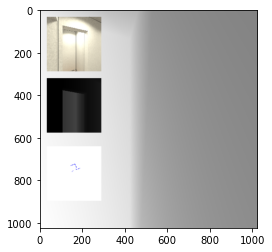

Enter actiond


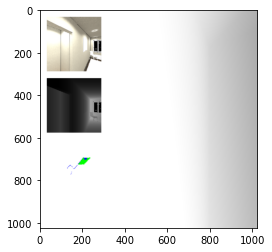

Enter actiond


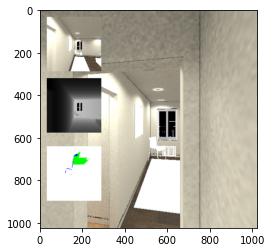

Enter actiond


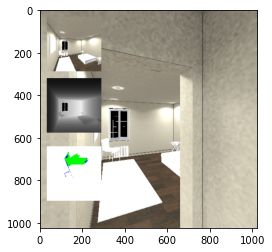

Enter actionw


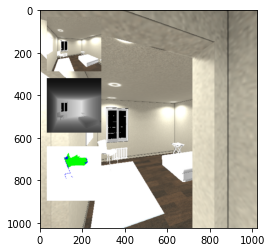

Enter actionw


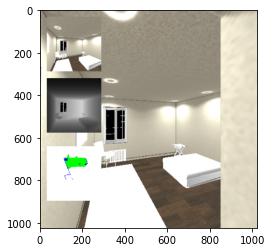

Enter actionw


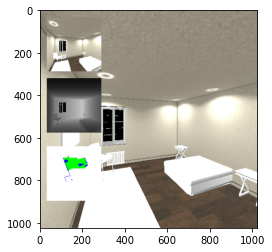

Enter actionx
video identifier: noop


[rawvideo @ 0x559188b74740] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [8]:
# def print_info(obs, metrics):
#     print(
#         "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}, Angle To Object: {}, Angle To Goal: {}".format(
#             obs["gripped_object_id"],
#             metrics["agent_to_object_distance"],
#             metrics["object_to_goal_distance"],
#             metrics["agent_to_object_angle"],
#             metrics["agent_to_goal_angle"],
#         )
#     )

record_path = "./debug-data/manual_control/"
assert os.path.exists(record_path)
crosshair = env._config.SIMULATOR.CROSSHAIR_POS

print(obs.keys())
# img_frame, top_down_map = render_frame(obs, metrics, crosshair)
# plt.imshow(np.array(img_frame))
# plt.show()
keystrokes = ["x", "w", "a", "d", "q", "e", "f", "l", "t"]
keystroke_action_map = {keystroke: i for i, keystroke in enumerate(keystrokes)}
frames = []
while not env.episode_over:
    keystroke = input("Enter action")

    if keystroke not in keystroke_action_map:
        continue
    if keystroke == "x":
        break
    elif keystroke == "t":
        avail_sids = list(env.sim.get_existing_object_ids())
        chosen_sids = input(f"Pick/Place from Semantic Ids: {avail_sids}").strip().split()
        chosen_sids = list(map(int, chosen_sids))
        if len(chosen_sids) == 1:
            chosen_sids = chosen_sids * 2
        elif len(chosen_sids) != 2:
            continue
    elif keystroke == "l":
        avail_sids = list(env.sim.get_existing_object_ids())
        chosen_sid = int(input(f"Pick/Place from Semantic Ids: {avail_sids}"))
        look_action = env.sim.look_at(chosen_sid)
        print(look_action)
    elif keystroke == "f":
        avail_sids = list(np.unique(obs["semantic"]))
        if 0 in avail_sids:
            avail_sids.remove(0)
        # add prompt
        chosen_sid = int(input(f"Pick/Place from Semantic Ids: {avail_sids}"))

    action = keystroke_action_map[keystroke]
    if keystroke == "t":
        nav_id, look_id = chosen_sids[0], chosen_sids[1]
        env.sim.snap_id_to_navmesh(nav_id, look_id)
    elif keystroke == "l":
        if look_action[0] == -1:
            action = keystroke_action_map["a"]
        elif look_action[0] == 1:
            action = keystroke_action_map["d"]
        elif look_action[1] == -1:
            action = keystroke_action_map["q"]
        elif look_action[1] == 1:
            action = keystroke_action_map["e"]
        else:
            print("Can't look at object")
            continue
        obs = env.step(action)
    elif keystroke == "f":
        obs = env.step(action={"action_args": {"sid": chosen_sid}, "action": action})
    else:
        obs = env.step(action)
    metrics = env.get_metrics()
#     print_info(obs, metrics)
#     display_sample(obs["rgb"], np.array([]), np.array([]), key_points=[[128, 160]])
#     plt.imshow(obs["fine_occupancy"])
#     plt.show()
    img_frame, top_down_map = render_frame(obs, metrics, crosshair)
    img_frame = np.array(img_frame)
    plt.imshow(img_frame)
    plt.show()
    frames.append(img_frame)

time_stamp = time.time()
curr_episode = env._current_episode
scene_name = os.path.split(curr_episode.scene_id.split(".")[0])[-1]
identifier = input("video identifier: ")
video_path = os.path.join(record_path, f"{scene_name}_{str(time_stamp)}_{identifier}")
images_to_video(frames, "./", video_path, fps=2)